In [70]:
# %pip install kagglehub pandas numpy matplotlib seaborn scikit-learn

In [71]:
# import pandas as pd

# cycles = pd.read_csv('datasets/cycleData.csv', sep='\t')
# cycles.head()

In [72]:
# # Extract date and times
# df_cycles = pd.DataFrame({
#     'date': pd.to_datetime(cycles['start_date']).dt.date,
#     'start_time': pd.to_datetime(cycles['start_date']).dt.time,
#     'end_time': pd.to_datetime(cycles['end_date']).dt.time,
#     'end_date': pd.to_datetime(cycles['end_date']).dt.date
# })

# # Group by date and get first start time and last end time
# daily_summary = df_cycles.groupby('date').agg({
#     'start_time': 'min',
#     'end_time': 'max'
# }).reset_index()

# daily_summary.head()

In [78]:
import pandas as pd

nodes = pd.read_csv('datasets/data.csv', sep='\t')

# add date to nodes
nodes['date'] = pd.to_datetime(nodes['time'], format='%y-%m-%dT%H:%M:%S.%f').dt.strftime('%Y-%m-%d')

nodes.head()

            X-axis       Y-axis
count  6476.000000  6476.000000
mean    871.820256   282.067383
std     724.065487   125.414760
min     129.658000   100.939000
25%     464.956750   173.553750
50%     636.026500   264.751000
75%     942.094250   362.640250
max    7433.146000  1182.661000


2024-11-10 average X-axis: 869.80
2024-11-11 average X-axis: 888.11


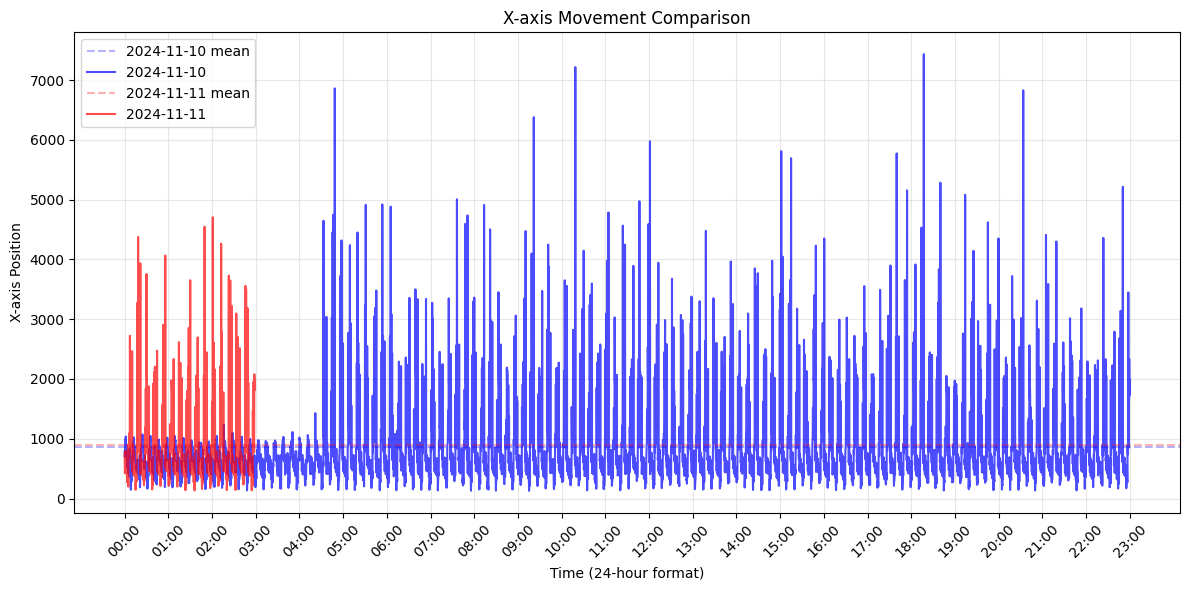

In [100]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# convert time to seconds
def time_to_seconds(time):
    h, m, s = map(int, time.split(':'))
    return h * 3600 + m * 60 + s

# Convert seconds to time format for better readability
def seconds_to_time(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    return f"{int(hours):02d}:{int(minutes):02d}"

def plot_data_for_dates(data, dates, property_name, start_time=None, end_time=None, colors=None):
    if colors is None:
        colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']  # Default colors for up to 7 days
    
    if len(dates) > 7:
        raise ValueError("Can only compare up to 7 days")
    
    plt.figure(figsize=(12, 6))
    
    plot_mean = []
    for i, date in enumerate(dates):
        day_data = data[data['date'] == date].copy()

        # mean of the property
        mean_value = day_data[property_name].mean()
        plot_mean.append(mean_value)
        print(f'{date} average {property_name}: {mean_value:.2f}')

        # plot a dotter line for the mean value
        plt.axhline(y=mean_value, color=f'{colors[i]}', linestyle='--', alpha=0.3, label=f'{date} mean')
        
        # Filter by time range if specified
        if start_time and end_time:
            day_seconds = [time_to_seconds(t.split('T')[1].split('.')[0]) for t in day_data['time']]
            start_seconds = time_to_seconds(start_time)
            end_seconds = time_to_seconds(end_time)
            
            time_mask = [(s >= start_seconds) & (s <= end_seconds) for s in day_seconds]
            day_data = day_data[time_mask]
            day_seconds = [s for s, m in zip(day_seconds, time_mask) if m]
        else:
            day_seconds = [time_to_seconds(t.split('T')[1].split('.')[0]) for t in day_data['time']]

        plt.plot(day_seconds, day_data[property_name], f'{colors[i]}-', 
                label=f'{date}', alpha=0.7)

    plt.title(f'{property_name} Movement Comparison')
    plt.xlabel('Time (24-hour format)')
    plt.ylabel(f'{property_name} Position')
    
    # Set x-axis ticks to show hours based on time range
    start_hour = int(start_time.split(':')[0]) if start_time else 0
    end_hour = int(end_time.split(':')[0]) if end_time else 24
    hours_to_show = np.arange(start_hour * 3600, (end_hour + 1) * 3600, 3600)
    plt.xticks(hours_to_show, [seconds_to_time(h) for h in hours_to_show], rotation=45)
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

dates_to_compare = nodes['date'].unique()
plot_data_for_dates(nodes, dates_to_compare, 'X-axis', 
                    start_time='00:00:00', end_time='23:00:00')